<a href="https://colab.research.google.com/github/tomasallemand/wvs-democracy-attitudes-ml/blob/main/notebooks/01_wvs_democracy_attitudes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <mark style="background:#FFF9C4"> ABSTRACT

This project analyzes how people evaluate democracy using World Values Survey (WVS) responses.

The goal is to build a simple, reproducible pipeline that cleans survey data, explores key patterns, and trains a binary classification model to predict **lower vs higher ratings of democracy**, based on other individual attitudes and perceptions.

**Audience:** anyone interested in applied, end-to-end data analysis (EDA + modeling) using real survey data.

# <mark style="background:#FFF9C4"> PROJECT GOAL

Identify which survey variables are most associated with **Q250 (importance of democracy)** and build a predictive model that classifies respondents into **lower vs higher democracy ratings**, using only information available in the survey responses.

# <mark style="background:#FFF9C4"> CONTEXTO
Se busca conocer el porcentaje de población que comparte ideas poco democráticas o autoritarias en una sociedad, independientemente de variaciones contextuales que favorezcan la proliferación temporal de este tipo de ideas.

Si bien las ideas antidemocráticas tienden a proliferar en contextos adversos de recesión económica o desaceleración del crecimiento (como cuestionamiento de la capacidad de este sistema de arrojar resultados), ello se trata de un patrón a nivel macro y puramente coyuntural.

En este sentido, se busca analizar qué variables micro tienden a fundamentar posturas autoritarias en los individuos, que puedan persistir independientemente de las variaciones contextuales y el devenir económico de una sociedad.

# <mark style="background:#FFF9C4"> PROBLEMA

* ¿De qué depende que una persona valore positivamente la democracia como sistema de gobierno?

* ¿Cuales son los factores más importantes que explican que una persona esté disconforme con este régimen?

# <mark style="background:#FFF9C4"> CONTEXTO ANALÍTICO
El dataset a utilizar se llama "World Value Surveys. Wave 7. v5.0" y tal como su nombre lo indica, trata de una encuesta de más de 200 preguntas sobre la percepción de diferentes temas sociopolíticos y económicos de las personas entrevistadas, tanto en términos objetivos (por ejemplo edad o ingresos) o bien subjetivos (por ejemplo, percepción de inseguridad). Se trata de variables cualitativas que han sido codificadas en el dataset como cuantitativas discretas.

A su vez, cada columna fue codificada como Q (question) y un número que representa el orden de esa pregunta.

Posee 295 columnas y han respondido 1003 personas en total

In [ ]:
!pip install catboost
# Librerías:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
import plotly.express as px
import re
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    roc_auc_score
)
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from IPython.display import display

In [ ]:
df=pd.read_csv('https://raw.githubusercontent.com/tomasallemand/wvs-democracy-attitudes-ml/main/data/WVS_FINAL_LIMPIO_7_v5.0.csv',delimiter=";")

In [ ]:
df.head()

,version,doi,B_COUNTRY,B_COUNTRY_ALPHA,C_COW_NUM,C_COW_ALPHA,A_YEAR,D_INTERVIEW,J_INTDATE,FW_END,...,WEIGHT4A,WEIGHT4B,RESEMAVALBWGT,RESEMAVALWGT,SECVALBWGT,Y001_1,Y001_2,Y001_3,Y001_4,Y001_5
0,1-5-0 (2020-11-16),doi.org/10.14281/18241.1,32.0,ARG,160.0,ARG,2017.0,32070001.0,20170709.0,201707.0,...,1.0,1.0,0.83,0.915,1.00,0.0,0.0,0.0,0.0,0.0
1,1-5-0 (2020-11-16),doi.org/10.14281/18241.1,32.0,ARG,160.0,ARG,2017.0,32070002.0,20170709.0,201707.0,...,1.0,1.0,1.00,1.000,0.83,1.0,1.0,0.0,1.0,1.0
2,1-5-0 (2020-11-16),doi.org/10.14281/18241.1,32.0,ARG,160.0,ARG,2017.0,32070003.0,20170710.0,201707.0,...,1.0,1.0,1.00,1.000,1.00,0.0,0.0,1.0,0.0,0.0
3,1-5-0 (2020-11-16),doi.org/10.14281/18241.1,32.0,ARG,160.0,ARG,2017.0,32070004.0,20170710.0,201707.0,...,1.0,1.0,1.00,1.000,1.00,1.0,1.0,0.0,0.0,0.0
4,1-5-0 (2020-11-16),doi.org/10.14281/18241.1,32.0,ARG,160.0,ARG,2017.0,32070005.0,20170710.0,201707.0,...,1.0,1.0,1.00,1.000,1.00,1.0,1.0,0.0,1.0,0.0


In [ ]:
#Eliminamos algunas columnas repetidas:
columns_to_drop = ['Q34_3','Q33_3','Q35_3',]
df = df.drop(columns=columns_to_drop)

# <mark style="background:#FFF9C4"> REMOCIÓN DE NULOS

**Sobre los datos**:
Al ser una encuesta, los valores nulos están cargados como valores negativos. Por ende, para remover los nulos, debemos tratar a los valores negativos.

In [ ]:
# Dimensionalidad original del dataset:
df.shape

(1003, 392)

In [ ]:
# 1) Nos quedamos SOLO con preguntas tipo Q### (sacamos metadata como version/doi/fechas/geo)
q_cols = [c for c in df.columns if re.fullmatch(r"Q\d+", str(c))]
df_model = df[q_cols].copy()

# 2) Pasamos todo a numérico (lo que no se pueda -> NaN)
df_model = df_model.apply(pd.to_numeric, errors="coerce")

# 3) En WVS, valores negativos suelen ser códigos de missing -> los tratamos como NaN
df_model = df_model.mask(df_model < 0, np.nan)

# 4) Mostramos columnas 100% vacías (para justificar limpieza)
all_nan_cols = df_model.columns[df_model.isna().all()].tolist()
print("Columnas 100% NaN (a eliminar):", all_nan_cols)

# 5) Eliminamos columnas 100% NaN
df_model = df_model.drop(columns=all_nan_cols)

df_model.shape

Columnas 100% NaN (a eliminar): []


(1003, 290)

# <mark style="background:#FFF9C4"> **EXPLORATORY DATA ANALYSIS**

In [ ]:
# Calcular la matriz de correlación (solo columnas numéricas)
# 1) quedarnos solo con columnas numéricas
df_num = df.select_dtypes(include=[np.number]).copy()

# 2) asegurar que Q250 exista y sea numérica (por si quedó como object)
if 'Q250' not in df_num.columns and 'Q250' in df.columns:
    df_num['Q250'] = pd.to_numeric(df['Q250'], errors='coerce')

# 3) correlación respecto de Q250
corr_q250 = df_num.corr(numeric_only=True)['Q250'].sort_values(ascending=False)

# 4) top 10 (incluye Q250 consigo misma)
top_10 = corr_q250.head(11)
top_10 = top_10.drop(index=["EQUALITY"], errors="ignore")
print(top_10)

Q250    1.000000
Q237    0.352128
Q243    0.351993
Q249    0.315733
Q112    0.274508
Q239    0.261981
Q91     0.252601
Q84     0.248363
Q251    0.244912
Q87     0.234607
Name: Q250, dtype: float64


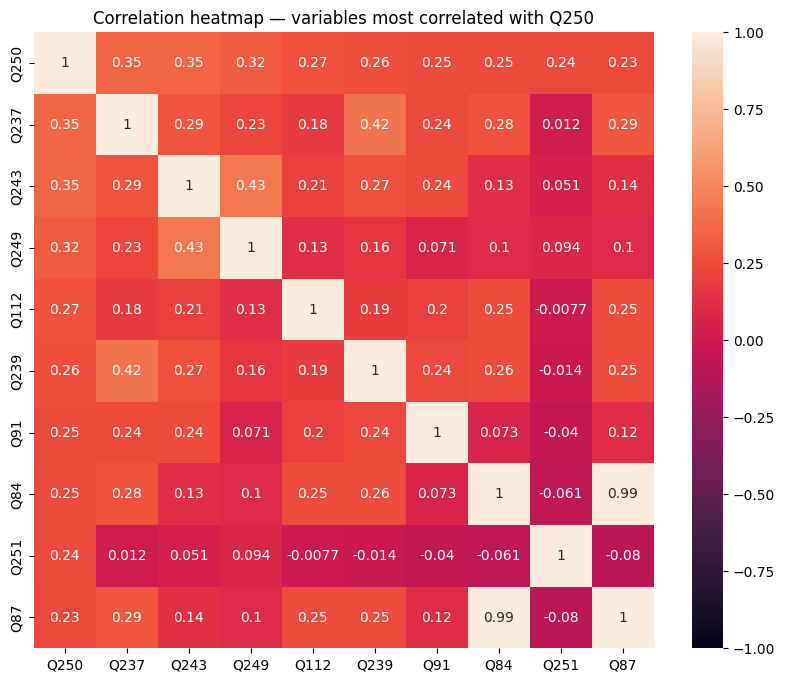

In [ ]:
# Heatmap: correlación entre las variables más correlacionadas con Q250 (solo numéricas)

cols = top_10.index.tolist()

# Aseguramos que existan en df y que sean numéricas
df_hm = df[cols].apply(pd.to_numeric, errors="coerce")

plt.figure(figsize=(10, 8))
sns.heatmap(df_hm.corr(), annot=True, vmin=-1, vmax=1)
plt.title("Correlation heatmap — variables most correlated with Q250")
plt.show()

De las 10 variables con mayor nivel de correlación respecto de "Y", las que poseen una correlación lógica esperada a la hora de explicar la importancia que las personas dan a la democracia (para evitar caer en correlaciones espurias) son:

- Q243: Democracy: People choose their leaders in free elections
- Q249: Democracy: Women have the same rights as men
- Q237: Political system: Having the army rule (relación inversa).
- Q197: Government has the right: Monitor all e-mails and any other information exchanged on the Internet
- Q127: Immigration in your country: Helps poor people establish new lives
- Q112: Perceptions of corruption in the country

In [ ]:
#Renombramos variables en aparencia más relevantes del dataset para crear visualizaciones más claras:
df_limpio = df_model.rename(columns={'Q250':'Importance_Democracy','Q243':'Trust_leaders','Q249':'Women_Man_EqualRights','Q112':'Corruption_Perception','Q237':'Army_Rule','Q197':'Government_rights','Q127':'Poor_inmigration','Q262':'Age'})

##Descripción de variables con mayor asociación a Q250:



Para el análisis exploratorio, nos enfocamos en el subconjunto de variables
que muestran mayor asociación con Q250 según la matriz de correlación.
Este análisis es descriptivo y no implica una selección final de variables,
la cual se realiza posteriormente dentro del pipeline de modelado.


In [ ]:
print(df_limpio.columns.intersection(top_10.index))

Index(['Q84', 'Q87', 'Q91', 'Q239', 'Q251'], dtype='object')


Todas ellas tienen una relación lógica con la percepción que puede tener una persona acerca de la democracia.
- En cuanto a la variable "**Q243** People choose their leaders in free elections", es lógico esperar que quienes crean que efectivamente los líderes de su país son elegidos en elecciones libres, crean en este sistema de gobierno, al menos en mayor medida respecto de quienes puedan considerar que las elecciones no son tan virtuosas.
- La variable "**"Q112"** Perception of corruption in the country" lógicamente incide en cómo una persona pueda percibir a la democracia: quienes perciban que la toma de decisiones que afectaran al conjunto de la sociedad obedecen a reglas diferentes a la voluntad popular podrían ser más propensos a cuestionar este régimen político.
- La variable "**"Q237"** "Political system: Having the army rule", es de especial interés ya que cuestiona acerca de la percepción que tienen las personas de un actor importante en el ordenamiento social: el ejército. Ha sido en la historia latinoamericana del siglo pasado el protagonista del régimen político alternativo a la democracia, y por ende es esperable que quienes tengan una mejor percepción de este régimen, sean más críticos de la democracia. La relación es entonces inversa (la correlación se ve positiva por el hecho de que las respuestas están invertidas: 1 significa muy de acuerdo, y 4 significa totalmente en desacuerdo).
- La variable "**Q197** Government has the right: Monitor all e-mails and any other information exchanged on the Internet" pone en cuestión los límites a los cuales los gobiernos podrían acceder en la vida privada de las personas. Los gobiernos más autoritarios tienden a gobernar mayores ámbitos de las personas que aquellos más liberales (y consistentes con las democracias). Si bien esta variable se limita a la aceptación que las personas tienen de la injerencia del Estado en un elemento puntual de la vida privada (los mails de las personas), puede entenderse a su vez como qué tan de acuerdo están con la injerencia de la política en asuntos privados.
- En cuanto a las variables "**Q249** Democracy: Women have the same rights as men" y "**Q127** Immigration in your country: Helps poor people establish new lives", estas intentan capturar la percepción que tiene una determinadad persona respecto a las minorías, lo cual es completamente relevante a la hora de evaluar qué tan democrática es esta persona, en tanto la democracia, especialmente en una forma de gobierno republicana como lo es en nuestro país, es un sistema que intenta proteger incluso a las "minorías" étnicas, raciales, de género, entre otras.

## **Análisis Univariado**:

**EDAD**:
Una variable que no utilizaremos en el modelo, pero es relevante para comprender las características de la muestra con la cual se está trabajando.

In [ ]:
# Histograma de distribución de la edad en la muestra:
px.histogram(df,x='Q262',title='Edad')

Podemos ver que hay cierto sesgo en la encuesta, donde gran parte de los participantes son más jóvenes. Habría que revisar si esto implica algún tipo de sesgo dado que diferentes fuentes fundamentan la existencia de diferencias ideológicas muy marcadas en función de los diferentes grupos etarios.

Para ello, vamos a revisar primero la distribución de "Q250", es decir, nuestra variable target, por sí sola, y luego la distribución de la misma en función de "Q262", es decir edad, para poder así observar la influencia o no del sesgo en cuestión.

**Veamos ahora la distribución de la valoración de la democracia como sistema de gobierno, es decir nuestra variable target (Q250)**:

In [ ]:
# Repasando las columnas de nuestro DataFrame:
df_limpio.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q281,Q282,Q283,Q284,Q285,Q286,Q287,Q288,Q289,Q290
0,1.0,2.0,4.0,4.0,1.0,4.0,1.0,2.0,1.0,1.0,...,6.0,NaN,NaN,1.0,1.0,2.0,3.0,5.0,1.0,32001.0
1,1.0,2.0,1.0,2.0,2.0,4.0,2.0,1.0,2.0,1.0,...,4.0,NaN,4.0,2.0,1.0,NaN,3.0,3.0,0.0,32001.0
2,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,...,6.0,NaN,7.0,2.0,1.0,NaN,3.0,5.0,1.0,32001.0
3,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,...,0.0,3.0,4.0,2.0,2.0,NaN,3.0,7.0,1.0,32001.0
4,1.0,1.0,1.0,3.0,1.0,3.0,1.0,2.0,2.0,1.0,...,4.0,NaN,4.0,2.0,1.0,4.0,3.0,4.0,1.0,32001.0


In [ ]:
#Histograma de distribución de percepción de democracia (Variable dependiente):
px.histogram(df_limpio,x='Importance_Democracy',title='Valoración de la democracia como sistema de gobierno')

**Revisamos el posible sesgo**:
Vamos a cruzar la distribución de la edad contra la valoración de la democracia como régimen político para descubrir una posible influencia de este sesgo en la variable objetivo:

In [ ]:
# Revisando que 'Q262' sea numérico (sin modificar df original)
df_vis = df.copy()
df_vis['Q262'] = pd.to_numeric(df_vis['Q262'], errors='coerce')

# Definir las categorías y los bins
categories = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85']
bins = [18, 25, 35, 45, 55, 65, 75, 85]

# Aplicar pd.cut
df_vis['Q262'] = pd.cut(df_vis['Q262'], bins=bins, labels=categories, right=False)

# Convertir a categoría ordenada
df_vis['Q262'] = pd.Categorical(df_vis['Q262'], categories=categories, ordered=True)

In [ ]:
# Crear el gráfico de cajas
fig = px.box(df_vis, x='Q262', y='Q250',
             title='Influencia del sesgo etario en el comportamiento de la variable Target: Importancia de la democracia vs Edad',
             labels={'Q262': 'Edad', 'Q250': 'Importancia de la democracia'},
             category_orders={'Q262': categories})


fig.update_layout(xaxis=dict(tickmode='array', tickvals=categories, ticktext=categories))

# Mostrar el gráfico
fig.show()

A pesar de nuestras suposiciones previas, no se observa un sesgo etario en función de la percepción de la democracia como sistema de gobierno.

##Análisis Bivariado:

**Gobierno militar contra importancia de la democracia**:

In [ ]:
# Gobierno militar contra importancia de la democracia:
fig = px.box(df_limpio, x='Army_Rule', y='Importance_Democracy', title='Democracia vs. Gobierno militar',
             category_orders={'Army_Rule': [1, 2, 3, 4],
                              'Importance_Democracy': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             labels={'Army_Rule': 'Gobierno militar', 'Importance_Democracy': 'Democracia'})

# Invertir el eje Y
fig.update_yaxes(categoryorder='array', categoryarray=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# Cambiar las etiquetas:
fig.update_yaxes(ticktext=['Not_democratic', '2', '3', '4', '5', '6', '7', '8', '9', 'Democratic'],
                 tickvals=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

fig.update_xaxes(ticktext=['Suport_Army_Rule', '2', '3', 'Dont_Support_Army_Rule'],
                 tickvals=['1', '2', '3', '4'])

# Mostrar el gráfico
fig.show()

Si agrupamos grupos de personas de acuerdon con su grado de aceptación de un posible gobierno militar, en el cual las personas del grupo 1 (army rule) consideran que sería muy buen gobierno, y las personas del grupo 4 (quienes consideran que sería muy malo) y sus valores intermedios, podemos ver que las personas que respondieron que el gobierno militar sería muy buen gobierno o simplemente un buen gobierno, tienen una mayor dispersión acerca de su concepción de la democracia. Mientras que quienes consideran que sería "malo" o "muy malo" tener un gobierno militar, concentran sus percepciones de la democracia como un sistema de gobierno totalmente importante.

**Género y Democracia**:

In [ ]:
# Percepción de Género y valoración de la democracia:
fig = px.box(df_limpio, x='Women_Man_EqualRights', y='Importance_Democracy', title='Géneros vs. Importancia de la democracia')

# Cambiar las etiquetas:
fig.update_yaxes(ticktext=['Not_democratic', '2', '3', '4', '5', '6', '7', '8', '9', 'Democratic'],
                 tickvals=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

fig.update_xaxes(ticktext=['Against_Equal_Rights','2', '3', '4', '5', '6', '7', '8', '9','Agree_with_equal_rights'],
                 tickvals=['1','2', '3', '4', '5', '6', '7', '8', '9', '10'])

# Mostrar el gráfico
fig.show()

Quienes comprenden la importancia de reconocer iguales derechos para ambos sexos, apoyan en un sentido mucho más homogéneo un régimen democrático. En contrapartida, quienes están en contra de la igualdad de género, tienen visiones más heterogéneas y dispersas de la democracia.

**Aceptación de injerencia del Estado como regulador de la vida privada de las personas contra percepción de la democracia**:

In [ ]:
# Crear el gráfico de cajas con las etiquetas personalizadas
fig = px.box(df_limpio,
             x='Government_rights',
             y='Importance_Democracy',
             title='Aceptación a las regulaciones del Estado de la vida privada y Democracia',
             category_orders={'Government_rights': ['Have the right', '2', '3', 'Not have the right'],
                              'Importance_Democracy': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             labels={'Government_rights': 'Injerencia del Gobierno',
                     'Importance_Democracy': 'Democracia'})

# Invertir el eje Y y cambiar las etiquetas
fig.update_yaxes(ticktext=['Not_democratic', '2', '3', '4', '5', '6', '7', '8', '9', 'Democratic'],
                 tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Cambiar las etiquetas del eje X
fig.update_xaxes(ticktext=['Have the right', '2', '3', 'Not have the right'],
                 tickvals=[1, 2, 3, 4])

# Mostrar el gráfico
fig.show()

Podemos notar una distribución similar de las variables a los casos anteriores. Las personas que consideran que hay aspectos de la vida privada que el Estado no debería regular (Si bien la pregunta se limita al derecho del Estado a leer mails privados, podemos entender que esta pregunta se extiende a la percepción que tienen las personas del derecho del Estado a intervenir en general en la vida privada de las personas, por ejemplo cómo vestirse, cuales noticias leer y cuales no, qué libros leer y cuales no, entre otras) son personas que tienen una percepción de la democracia mucho más positiva y homogenea que quienes consideran que el Estado tiene derecho a regular aspectos privados e íntimos de las personas, que a su vez tienen una visión mucho más heterogénea de la democracia, incluyendo a personas que no están de acuerdo con ese régimen político.

**Confianza en que los líderes son electos de forma libre y genuina contra valoración de la democracia como régimen político**:

In [ ]:
# Crear el gráfico de cajas con las etiquetas personalizadas
fig = px.box(df_limpio,
             x='Trust_leaders',
             y='Importance_Democracy',
             title='Elecciones libres y democracia',
             category_orders={'Trust_leaders': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                              'Importance_Democracy': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             labels={'Trust_leaders': 'Elecciones libres',
                     'Importance_Democracy': 'Democracia'})

# Invertir el eje Y y cambiar las etiquetas
fig.update_yaxes(ticktext=['Not_democratic', '2', '3', '4', '5', '6', '7', '8', '9', 'Democratic'],
                 tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Cambiar las etiquetas del eje X
fig.update_xaxes(ticktext=['Dont_trust_free_elections', '2', '3', '4', '5', '6', '7', '8', '9', 'Trust_free_elections'],
                 tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Mostrar el gráfico
fig.show()

En el gráfico podemos observar cómo las personas que creen que los líderes son realmente electos en elecciones libres (dicho de otra manera, las personas que creen que la democracia funciona en tanto mecanismo de selección de dirigentes), son los grupos que creen de manera más consistente y con menor dispersión en la democracia como la mejor forma de ordenamiento social.

Por su parte, las personas qué creen en menor medida en la existencia de elecciones verdaderamente libres que generen resultados genuinos, muestran una percepción más heterogénea de la democracia como régimen político.

**Percepción de Corrupción y Valoración de la Democracia**:

In [ ]:
# Crear el gráfico de cajas con las etiquetas personalizadas
fig = px.box(df_limpio,
             x='Corruption_Perception',
             y='Importance_Democracy',
             title='Percepción de Corrupción y Democracia',
             category_orders={'Corruption_Perception': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                              'Importance_Democracy': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             labels={'Corruption_Perception': 'Percepción de Corrupción',
                     'Importance_Democracy': 'Democracia'})

# Invertir el eje Y y cambiar las etiquetas
fig.update_yaxes(ticktext=['Not_democratic', '2', '3', '4', '5', '6', '7', '8', '9', 'Democratic'],
                 tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Cambiar las etiquetas del eje X
fig.update_xaxes(ticktext=['There is not Corruption', '2', '3', '4', '5', '6', '7', '8', '9', 'There is abundant Corruption'],
                 tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Mostrar el gráfico
fig.show()

A pesar de la correlación entre las variables, no se distingue de manera tan clara que haya una tendencia clara sobre la valoración de la democracia en función de la percepción de corrupción en el país.

# <mark style="background:#FFF9C4"> X & Y





In [ ]:
print("Top 15 columnas con más NaN (antes de modelar):")
display((df_model.isna().mean().sort_values(ascending=False).head(15) * 100).to_frame("% NaN"))

# =========================================================
# 1. Target y features
y_raw = df_model["Q250"].copy()

# nos quedamos SOLO con filas donde el target existe
mask = y_raw.notna()
df_model = df_model.loc[mask].copy()
y_raw = y_raw.loc[mask].copy()

Top 15 columnas con más NaN (antes de modelar):


,% NaN
Q276,64.107677
Q282,64.107677
Q280,64.107677
Q89,41.475573
Q86,38.683948
Q87,35.194417
Q91,29.611167
Q88,25.523430
Q207,24.327019
Q283,24.127617


In [ ]:
# Vista clara: distribución ordenada de Q250 (sin NaN)
print("Q250 unique values:", sorted(y_raw.dropna().unique()))
print("Q250 value counts:\n", y_raw.value_counts(dropna=False).head(20))

vc = y_raw.dropna().value_counts().sort_index()
print("Distribución Q250 (ordenada):")
print(vc)

print("\nPorcentaje acumulado:")
print((vc.cumsum() / vc.sum()).round(3))

Q250 unique values: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0)]
Q250 value counts:
 Q250
10.0    540
8.0     145
9.0     136
7.0      73
6.0      44
5.0      30
4.0      13
3.0       6
1.0       1
2.0       1
Name: count, dtype: int64
Distribución Q250 (ordenada):
Q250
1.0       1
2.0       1
3.0       6
4.0      13
5.0      30
6.0      44
7.0      73
8.0     145
9.0     136
10.0    540
Name: count, dtype: int64

Porcentaje acumulado:
Q250
1.0     0.001
2.0     0.002
3.0     0.008
4.0     0.021
5.0     0.052
6.0     0.096
7.0     0.170
8.0     0.316
9.0     0.454
10.0    1.000
Name: count, dtype: float64


In [ ]:
# Binarización explícita:
    # Definimos "baja confianza democrática" como valores 1-8 y "alta" como 9-10,
    #para evitar una clase extremadamente minoritaria,
    # dado que valores 9–10 concentran la mayoría de las observaciones.

THRESHOLD = 8
y = (y_raw <= THRESHOLD).astype(int)

X = df_model.drop(columns=["Q250"]).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Class balance (train):\n", y_train.value_counts(normalize=True))

Train size: (791, 289) Test size: (198, 289)
Class balance (train):
 Q250
0    0.683944
1    0.316056
Name: proportion, dtype: float64


In [ ]:
print(df_model['Q250'].value_counts())

Q250
10.0    540
8.0     145
9.0     136
7.0      73
6.0      44
5.0      30
4.0      13
3.0       6
1.0       1
2.0       1
Name: count, dtype: int64


# <mark style="background:#FFF9C4"> PREPROCESSOR:

In [ ]:
def negative_to_nan(X):
    if isinstance(X, pd.DataFrame):
        X = X.copy()
        for col in X.columns:
            X[col] = pd.to_numeric(X[col], errors="coerce")
        X = X.mask(X < 0, np.nan)
        return X
    else:
        X = X.copy()
        X[X < 0] = np.nan
        return X


In [ ]:
numeric_features = list(X.columns)

preprocess = Pipeline(steps=[
    ("neg_to_nan", FunctionTransformer(negative_to_nan, feature_names_out="one-to-one")),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[("num", preprocess, numeric_features)],
    remainder="drop"
)

# Feature selection dentro del pipeline (evita leakage)
feature_selector = SelectKBest(score_func=f_classif, k=6)  # k acá lo dejamos como valor inicial, después buscamos el mejor en la grilla.

In [ ]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('neg_to_nan',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function negative_to_nan at 0x7d84d65da340>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('scaler', StandardScaler())]),
                                 ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7',
                                  'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14',
                                  'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20',
                                  'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26',
                                  'Q27', 'Q28', 'Q29', 'Q30', ...])])

# <mark style="background:#FFF9C4"> MODELADO

Se busca desarrollar un modelo que logre explicar y predecir el comportamiento de la variable "Valoración de la Democracia" en función del comportamiento de las variables independientes seleccionadas para tal caso.

Dado que la variable target es de naturaleza cuantitativa discreta, es decir categórica, intentamos predecir un determinado valor categórico de Y en función de nuestras X, vamos a trabajar con un modelo de clasificación multiclase.

##GridSearchCV:
Optimización de hiperparámetros

In [ ]:
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("select", feature_selector),
    ("estimator", LogisticRegression())
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params_grid = [
    {
        "select__k": [4, 6, 8],
        "estimator": [LogisticRegression(max_iter=1000)],
        "estimator__C": [0.1, 1, 4, 10],
        "estimator__solver": ["liblinear"]
    },
    {
        "select__k": [4, 6, 8],
        "estimator": [RandomForestClassifier(random_state=42)],
        "estimator__n_estimators": [300, 500],
        "estimator__max_depth": [5, 7, 9]
    },
    {
        "select__k": [4, 6, 8],
        "estimator": [XGBClassifier(
            random_state=42,
            eval_metric="logloss",
            n_jobs=-1
        )],
        "estimator__n_estimators": [200, 300],
        "estimator__max_depth": [3, 5],
        "estimator__learning_rate": [0.05, 0.1]
    },
    {
        "select__k": [4, 6, 8],
        "estimator": [CatBoostClassifier(
            random_state=42,
            verbose=0
        )],
        "estimator__iterations": [200, 300],
        "estimator__depth": [3, 5],
        "estimator__learning_rate": [0.05, 0.1]
    }
]

GS = GridSearchCV(
    estimator=pipe,
    param_grid=params_grid,
    cv=cv,
    scoring="f1",      # mejor que accuracy para clasificación binaria
    n_jobs=-1
)

GS.fit(X_train, y_train)

print("Best params:", GS.best_params_)
print("Best CV score (F1):", GS.best_score_)

Best params: {'estimator': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...), 'estimator__learning_rate': 0.05, 'estimator__max_depth': 3, 'estimator__n_estimators': 200, 'select__k': 4}
Best CV score (F1): 0.6168186699686907


In [ ]:
best_model = GS.best_estimator_

# Baseline --> vemos si el modelo performa mejor que un nivel base:
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)
base_pred = baseline.predict(X_test)

print("BASELINE accuracy:", accuracy_score(y_test, base_pred))
print("BASELINE F1:", f1_score(y_test, base_pred))

# Modelo final
y_pred = best_model.predict(X_test)

print("\nMODEL accuracy:", accuracy_score(y_test, y_pred))
print("MODEL F1:", f1_score(y_test, y_pred))

print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# ROC-AUC (si el estimador tiene predict_proba)
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test)[:, 1]
    print("MODEL ROC-AUC:", roc_auc_score(y_test, y_proba))

BASELINE accuracy: 0.6818181818181818
BASELINE F1: 0.0

MODEL accuracy: 0.7525252525252525
MODEL F1: 0.5504587155963303

Confusion matrix:
 [[119  16]
 [ 33  30]]

Classification report:
               precision    recall  f1-score   support

           0       0.78      0.88      0.83       135
           1       0.65      0.48      0.55        63

    accuracy                           0.75       198
   macro avg       0.72      0.68      0.69       198
weighted avg       0.74      0.75      0.74       198

MODEL ROC-AUC: 0.7414462081128748


In [ ]:
#el pipeline ganador
GS.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('neg_to_nan',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function negative_to_nan at 0x7d84d65da340>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Q1', 'Q2', 'Q3', 'Q4', 'Q5',
                                                   'Q6', 'Q7', 'Q8', 'Q9',
                                                   'Q10', 'Q11', 'Q12', 'Q1...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [ ]:
#Vemos los parámetros del modelo ganador:
GS.best_params_

{'estimator': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=-1,
               num_parallel_tree=None, ...),
 'estimator__learning_rate': 0.05,
 'estimator__max_depth': 3,
 'estimator__n_estimators': 200,
 'select__k': 4}

In [ ]:
#Guardamos el modelo final
modelo_final=GS.best_estimator_

In [ ]:
modelo_final.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('neg_to_nan',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function negative_to_nan at 0x7d84d65da340>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Q1', 'Q2', 'Q3', 'Q4', 'Q5',
                                                   'Q6', 'Q7', 'Q8', 'Q9',
                                                   'Q10', 'Q11', 'Q12', 'Q1...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=-1,
                               num_parallel_tree=None, ...))])

# <mark style="background:#FFF9C4"> MODELO FINAL

In [ ]:
# Predicción:
print(f"Final score: {round(modelo_final.score(X_test,y_test),4)*100}%")

Final score: 75.25%


El modelo ganador en la grilla del GridSearch ha sido un Random Forest Classifier. Sin embargo, es importante entender que este método ha considerado únicamente a los datos de entrenamiento para elegir el mejor modelo. Cuando consideramos también a los datos de testeo, podemos notar que el modelo con los mejores resultados es la Regresión Logística, por lo que nos quedaremos con este modelo como ganador, el cual muestra una precisión del 62% aproximadamente.

# <mark style="background:#FFF9C4"> PERSISTENCIA

In [ ]:
from joblib import dump
dump(modelo_final, "modelo_final_wvs.joblib", compress=("gzip", 9))

['modelo_final_wvs.joblib']